In [1]:
from nilearn.plotting import plot_stat_map
from neurovlm.data import fetch_data
from neurovlm import NeuroVLM
from neurovlm.data import load_latent, load_dataset

In [2]:
# Fetch models and datasets
fetch_data()

# Load networks examples images
networks = load_latent("networks_neuro")

Data fetch complete. Cache directory: /Users/ryanhammonds/.cache/huggingface/hub


## Text-to-Brain: Generative

In [3]:
nvlm = NeuroVLM()
result = nvlm.to_brain(["vision", "default mode network"], model="mse")
images = result.to_nifti()

There are adapters available but none are activated for the forward pass.


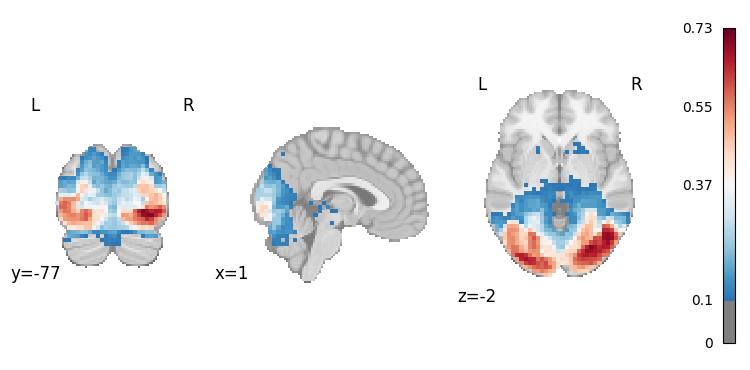

In [4]:
plot_stat_map(images[0], threshold=0.1, draw_cross=False);

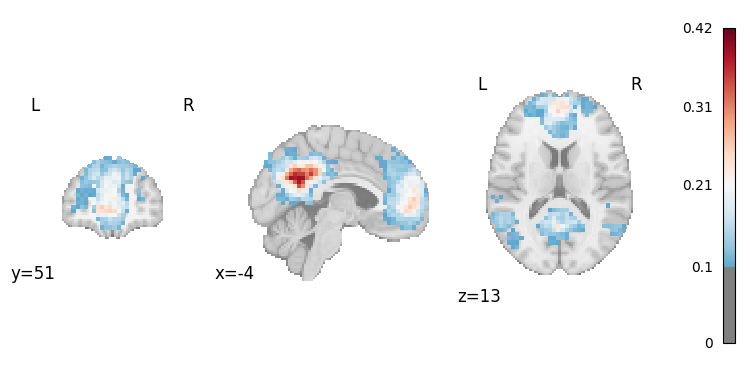

In [5]:
plot_stat_map(images[1], threshold=0.1, draw_cross=False);

## Text-to-Brain: Contrastive

Instead of genearting a neuroimage, we can lookup similar neuroimages in a dataset. Here the networks and PubMed datasets contain images compared against.

In [6]:
nvlm = NeuroVLM()
result = nvlm.to_brain(["motor"], model='infonce')
result.top_k(2) # each row pairs to a neuorimage that is most similar to the text query

There are adapters available but none are activated for the forward pass.


,dataset,title,description,cosine_similarity
0,networks,Shirer,Sensorimotor,0.438795
1,networks,WashU,Effector-hand,0.432333
2,pubmed,Group-level variations in motor representation...,Navigated transcranial magnetic stimulation (T...,0.466430
3,pubmed,Ipsilateral motor cortex activation on functio...,"Distal, unilateral hand movements can be assoc...",0.459416


## Brain-to-Text: Contrastive

Here we use an auditory map at input. We use the contrastive model to rank the most similar text across a few datasets.

In [7]:
nvlm = NeuroVLM()
result = nvlm.to_text(networks["Du"]["AUD"])
result.top_k(2) # return top-2 matches per dataset

,dataset,title,description,cosine_similarity
0,cogatlas,auditory stream segregation,The perceptual grouping of sounds to form cohe...,0.437669
1,cogatlas,auditory encoding,The process of storing auditory information in...,0.431347
2,networks,Auditory,Auditory network (AUD; auditory cortex network...,0.470542
3,networks,Language,Language network (LAN; perisylvian language ne...,0.204501
4,pubmed,The processing of temporal pitch and melody in...,An fMRI experiment was performed to identify t...,0.526884
5,pubmed,"Heschl's gyrus, posterior superior temporal gy...",A part of the auditory system automatically de...,0.504547
6,wiki,Temporal masking,Temporal masking or non-simultaneous masking o...,0.489581
7,wiki,Melodic expectation,"In music cognition and musical analysis, the s...",0.454363


## Brain-to-Text: Generative

Here we use the auditory map again. We use the contrastive model to rank the most similar text across a data-derived ngram dataset. The top-k terms are then passed to an LLM for generation.

In [8]:
from neurovlm.retrieval_resources import _load_ngram, _load_latent_ngram

# Load ngrams data
latent_ngram = _load_latent_ngram()
ngrams = _load_ngram() # to-do integrate ngram dataset into NeuroVLM class

# Top-10 terms based on cosine similarity
cosine_similarity = result.query_embeddings[0] @ latent_ngram.T
indices_sorted = cosine_similarity.argsort(descending=True)
labels = ngrams[indices_sorted[:4]].tolist()
labels

['music', 'audio', 'sound', 'auditory regions']

In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "HuggingFaceTB/SmolLM2-360M-Instruct"
device = "mps" if torch.backends.mps.is_available() else "cpu"
dtype  = torch.float16 if device == "mps" else torch.float32

tok = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=dtype).to(device).eval()

if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

messages = [
    {"role": "system", "content": "Write a short paragraph explaing the following terms in the context of neuroimaging."},
    {"role": "user",   "content": "\n".join(labels)},
]

prompt = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = tok(prompt, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    out = model.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=False,   # deterministic
        num_beams=1,       # deterministic
        temperature=None,  # ignored when do_sample=False
        top_p=None,
        pad_token_id=tok.eos_token_id,
        eos_token_id=tok.eos_token_id,
    )

new_tokens = out[0, inputs["input_ids"].shape[-1]:]
print(tok.decode(new_tokens, skip_special_tokens=True))


The auditory regions, also known as the auditory cortex, are areas in the brain responsible for processing and interpreting sound. These regions are located in the temporal lobe, specifically in the left hemisphere, and are involved in the perception of sound, including music. The auditory regions are divided into several sub-regions, each specializing in different aspects of sound, such as frequency, amplitude, and temporal characteristics. The auditory regions are also closely linked to other brain regions, such as the auditory association cortex, which is involved in the processing of music and other auditory stimuli.
